# MIMIC Analysis

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys 
sys.path.append('../lib/functions')

# MIMIC Statistics

In [60]:
mimic = pd.read_csv('../data/mimic/mimic.csv')
mimic = mimic.set_index(['SUBJECT_ID', 'HADM_ID'])

synthetic_mimic = pd.read_csv('../../mimic/Generated_data_TRAIN_CATSAM30.csv')
synthetic_mimic = synthetic_mimic.set_index(['SUBJECT_ID', 'HADM_ID'])

In [61]:
mimic.head()

,,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,DIED,LOS,HR_MIN_DAY1,...,V81,V83,V84,V85,V86,V87,V88,V90,V91,ICU
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,
23,152223,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,71,0,1.2641,85.0,...,0,0,0,0,0,0,0,0,0,CSRU
25,129635,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,M,58,0,3.5466,49.0,...,0,0,0,0,0,0,0,0,0,CCU
26,197661,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,M,72,0,2.1407,60.0,...,0,0,0,0,0,0,0,0,0,CCU
28,162569,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,74,0,1.1224,74.0,...,0,0,0,0,0,0,0,0,0,CSRU
30,104557,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,M,-285,0,1.8472,68.0,...,0,0,0,0,0,0,0,0,0,CCU


In [62]:
synthetic_mimic.head()

,,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,DIED,LOS,HR_MIN_DAY1,...,V81,V83,V84,V85,V86,V87,V88,V90,V91,ICU
SUBJECT_ID,HADM_ID,,,,,,,,,,,,,,,,,,,,,
14960.0,159966.0,2.0,48.0,3.0,3.0,14.0,0.0,54.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
57023.0,147727.0,2.0,48.0,3.0,3.0,14.0,0.0,54.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
80989.0,149481.0,2.0,48.0,3.0,3.0,14.0,0.0,54.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
27873.0,151475.0,2.0,48.0,3.0,3.0,14.0,0.0,54.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
84049.0,194061.0,2.0,48.0,3.0,3.0,14.0,0.0,54.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


##### Variables types

In [63]:
import utilities
types = utilities.types(mimic)
synthetic_types = utilities.types(synthetic_mimic)

In [64]:
print(types.value_counts())
print(synthetic_types.value_counts())

Binary         1011
Numerical        49
Categorical       7
Name: type, dtype: int64
Binary       1061
Numerical       6
Name: type, dtype: int64


Categorical variables: 
    - Demographic: Insurance, Language, Religion, Marital status, Ethnicity & Age
    - ICU (Unit where the patient is): CCU, CSRU, MICU, SICU, TSICU
    
Binary variables:
    - Demographic: Gender
    - Diagnosis (Whether the patient contracted the disease or not)
    - Survival (Whether the patient dies during his stay or not)
    
Numerical variables:
    - Length of stay
    - First daily vitals: Heart rate, Blood Pressure, ...
    - Second daily vitals: Heart rate, Blood Pressure, ...

###### Imbalance class problem
    - more than 90% of patients survived after their stay at the hospital
    - less than 10% of patients die during their stay at the hospital

In [65]:
mimic['DIED'].value_counts(normalize=True)

0    0.919783
1    0.080217
Name: DIED, dtype: float64

In [66]:
synthetic_mimic['DIED'].value_counts(normalize=True)

0.0    0.999328
1.0    0.000672
Name: DIED, dtype: float64

## Analysis

### Categorical variables

##### Distribution of patients according to ICU

In [67]:
def relative_frequency(df, column):
    return df[column].value_counts(normalize=True).sort_index()

def relative_frequency_plot(df, column):
    fig, ax = plt.subplots(figsize=(13, 6))
    rel_freq = relative_frequency(df, column)
    rel_freq.plot(kind='bar', title='Relative frequency of patients according to ' + column, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Relative Frequency')
    plt.show()

In [68]:
def conditional_relative_frequency(df, columns, target='DIED'):
    cond_rel_freq = \
        df.groupby(columns + [target])[target].count() / df.groupby(columns + [target])[target].count().sum()
    return cond_rel_freq

def conditional_relative_frequency_plot(df, columns, target='DIED'):
    fig, ax = plt.subplots(figsize=(13, 6))
    rel_freq = conditional_relative_frequency(df, columns, target).unstack()
    rel_freq.plot(kind='bar', stacked=True, title='Relative frequencies of patients according to ' + ' '.join(columns), ax=ax)
    ax.set_xlabel(columns)
    ax.set_ylabel('Relative Frequencies')
    plt.show()

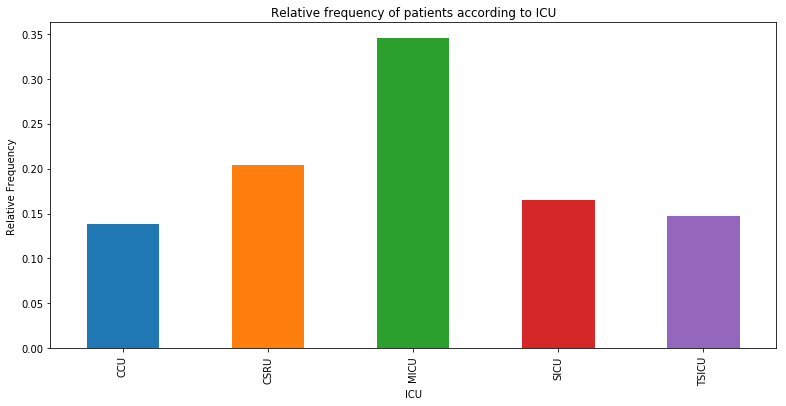

In [69]:
relative_frequency_plot(mimic, 'ICU')

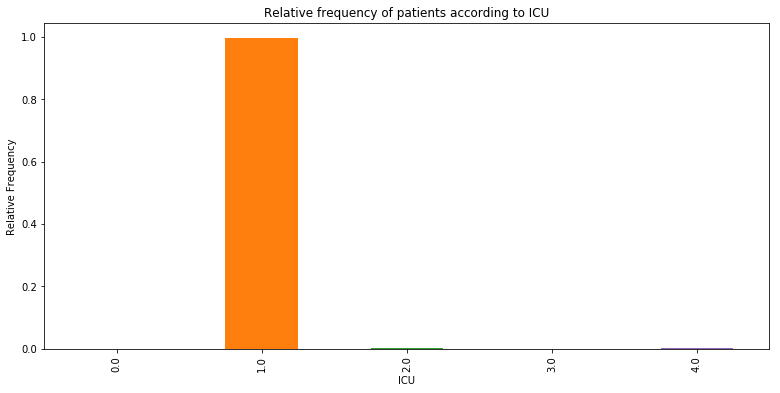

In [70]:
relative_frequency_plot(synthetic_mimic, 'ICU')

Most of the patients (~35%) are taken to Medical Intensive Care Unit and the rest are dispatched between the other units.

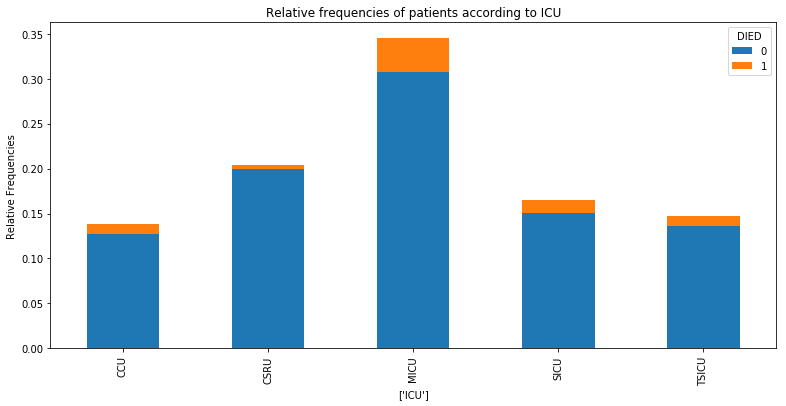

In [35]:
conditional_relative_frequency_plot(mimic, columns=['ICU'], target='DIED')

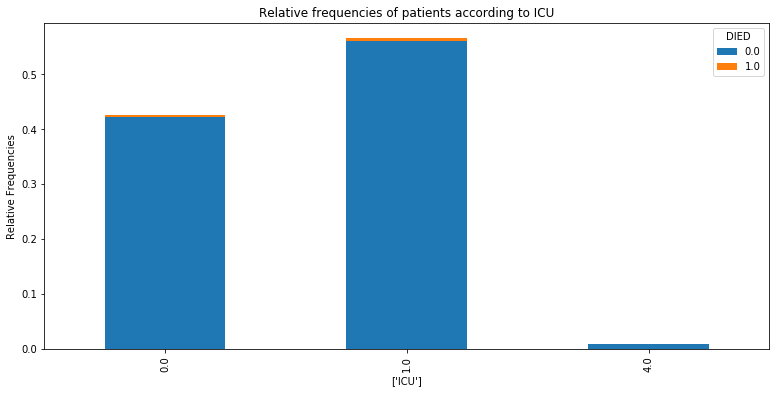

In [37]:
conditional_relative_frequency_plot(synthetic_mimic, columns=['ICU'], target='DIED')

#### Distribution of patients according to Age

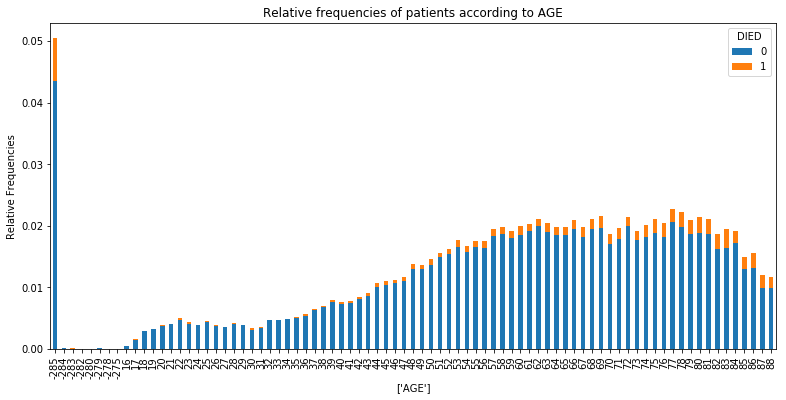

In [13]:
conditional_relative_frequency_plot(mimic, columns=['AGE'], target='DIED')

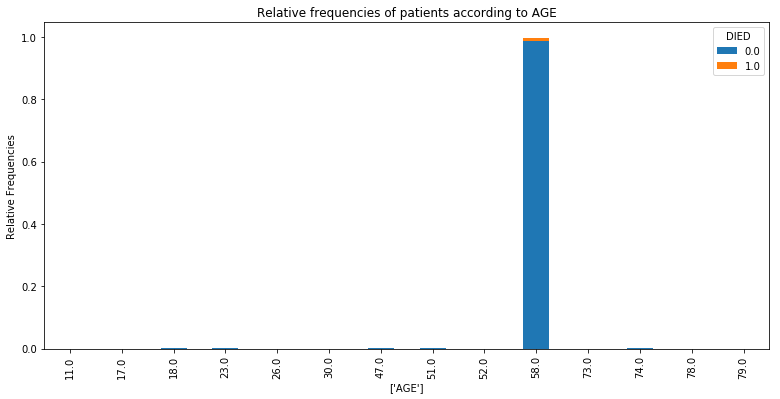

In [40]:
conditional_relative_frequency_plot(synthetic_mimic, columns=['AGE'], target='DIED')

Age contains negative values which, after some digging, correspond to people whose age is beyond 88 and is not well handled by what records the age.

We can also see a tendancy that age is correlated with the death during the stay at the hospital (the older, the more chances the patient dies).

##### Work in progress

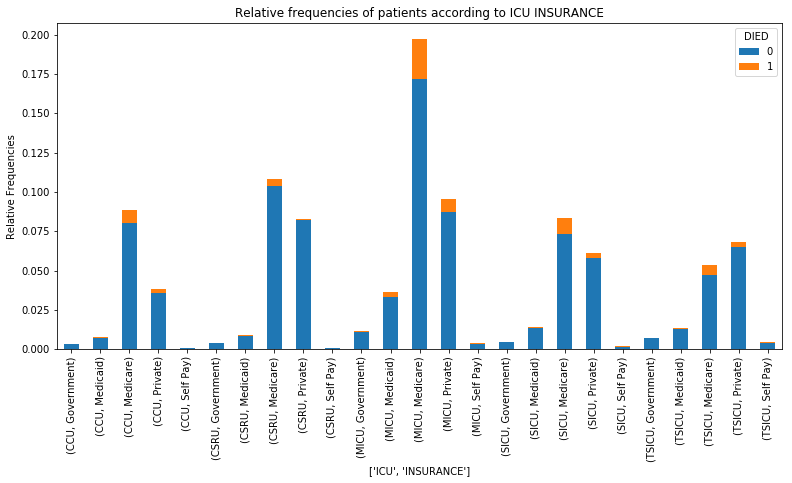

In [14]:
conditional_relative_frequency_plot(mimic, columns=['ICU', 'INSURANCE'], target='DIED')

##### Correlation between target (death during the stay at hospital) and categorical variables

In [15]:
def correlation_with_target(df, columns, target='DIED'):
    corr_with_target = pd.concat([pd.get_dummies(df[columns]), mimic[target]], axis=1).corr()[target]
    corr_with_target = corr_with_target.drop(target)
    return corr_with_target

def correlation_with_target_plot(df, columns, target='DIED'):
    fig, ax = plt.subplots(figsize=(30, 7))
    corr_with_target = correlation_with_target(df, columns, target=target)
    plt.xticks(rotation=90)
    plt.scatter(corr_with_target.index, corr_with_target)
    plt.show()

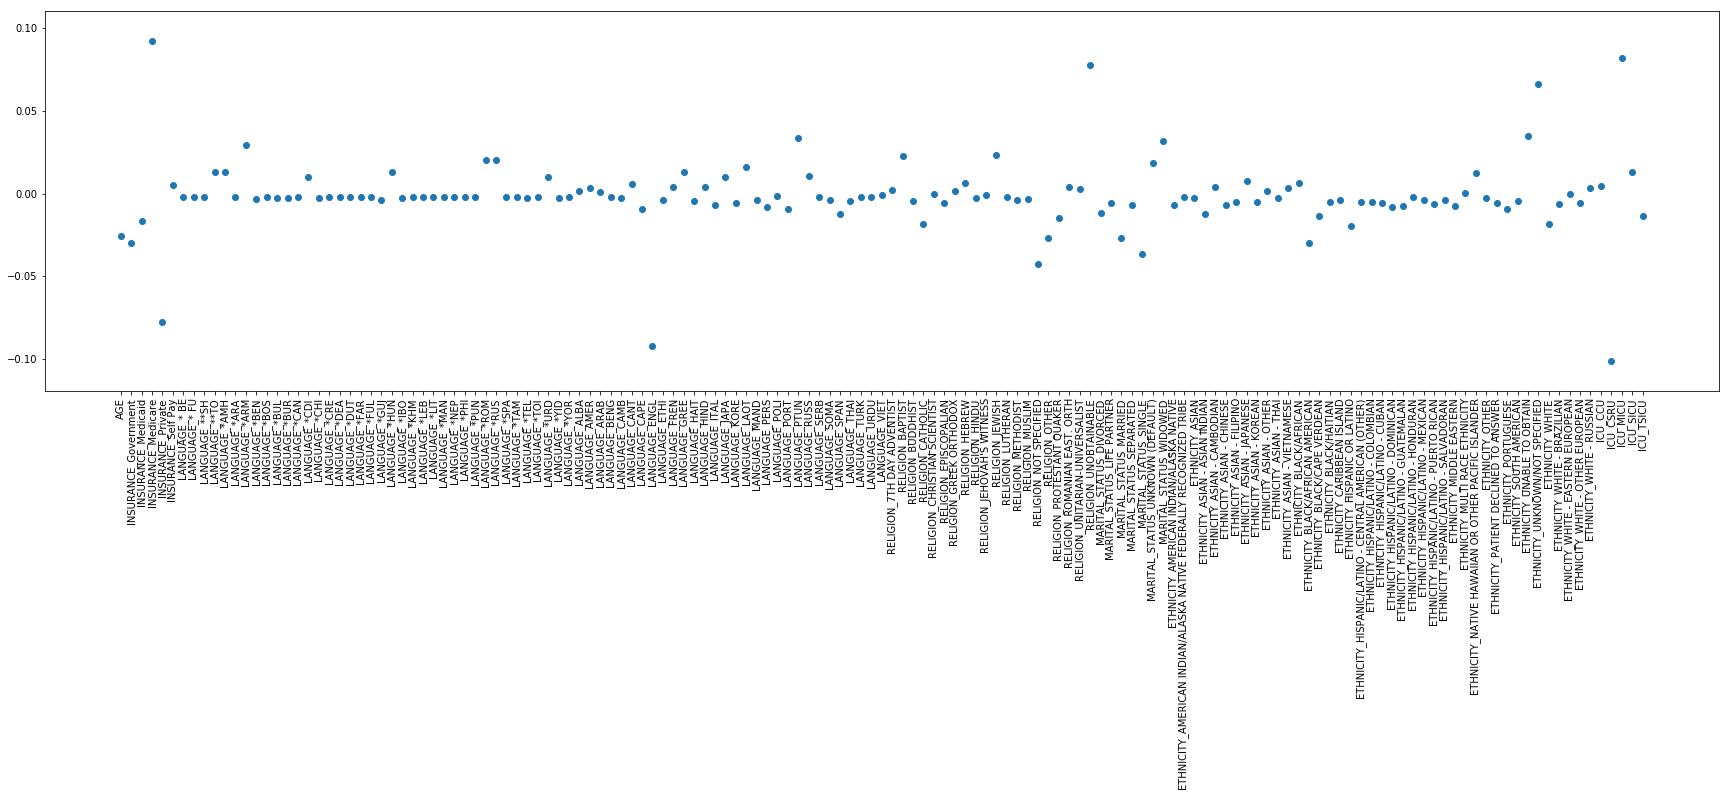

In [16]:
categorical_columns = types[types=='Categorical'].index
correlation_with_target_plot(mimic, columns=categorical_columns, target='DIED')

In [17]:
corr = correlation_with_target(mimic, columns=categorical_columns, target='DIED')

In [71]:
test = mimic['HR_MIN_DAY1'] 
test_norm = (test - test.mean()) / test.std()

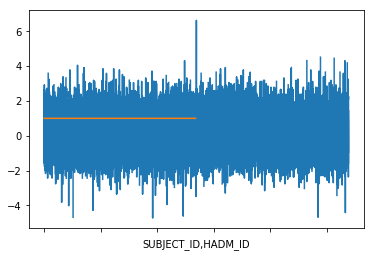

In [72]:
test_norm.plot()
synthetic_mimic['HR_MIN_DAY1'].plot()